In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot, network_sender_receiver
from filters import butter_lowpass
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm

C:\Users\Toldbodgade1\anaconda3\envs\thesis_env\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
def get_data():

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y

In [3]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss
# Remember to double check padding and general design of NN_tx and NN_rx

Xtrain, ytrain = get_data()
Xtest, ytest = get_data()

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

0.8944271909999159
Using GPU
0  loss: 1.570759654045105
0  acc: 0.22168000042438507


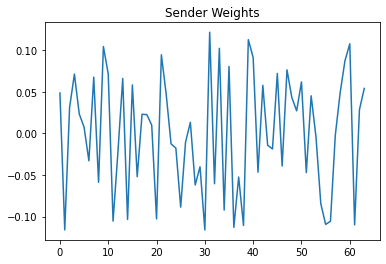

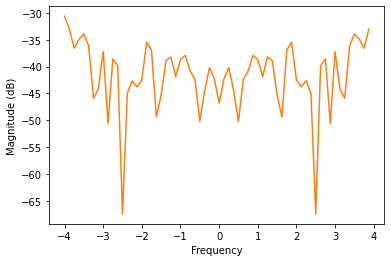

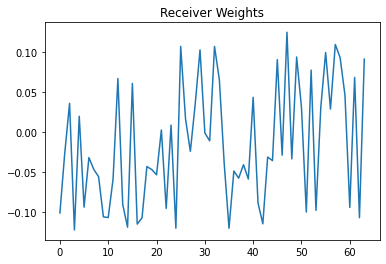

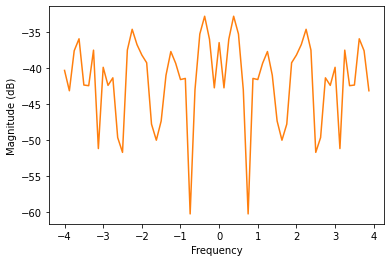

100  loss: 1.0704396963119507
100  acc: 0.4764699935913086


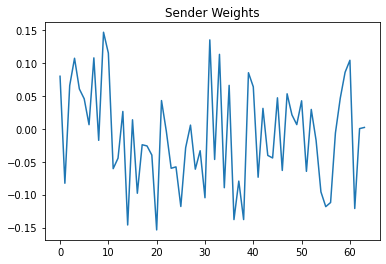

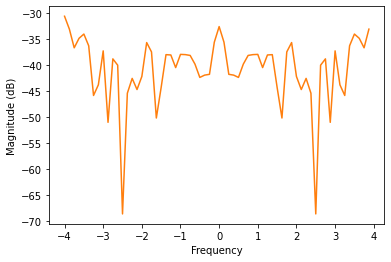

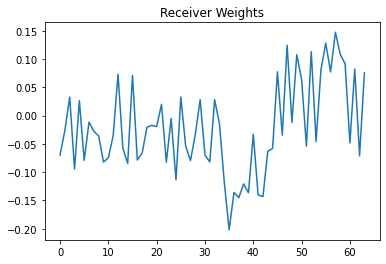

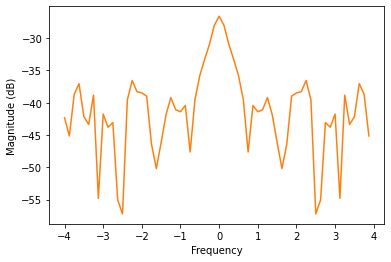

200  loss: 1.0257525444030762
200  acc: 0.4953799843788147


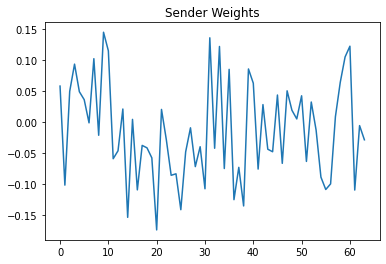

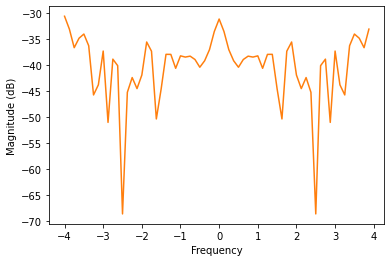

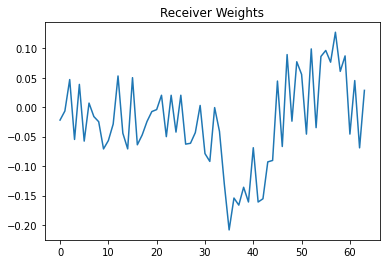

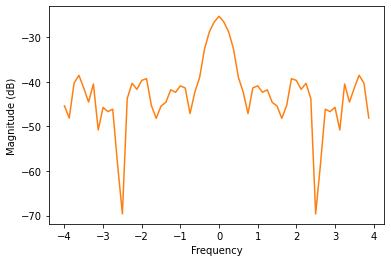

300  loss: 1.0075948238372803
300  acc: 0.5113399624824524


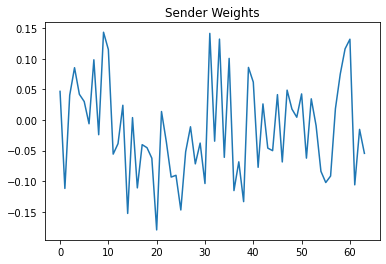

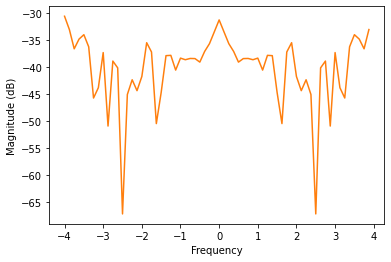

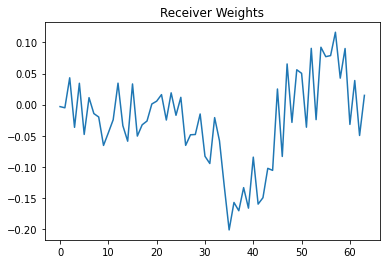

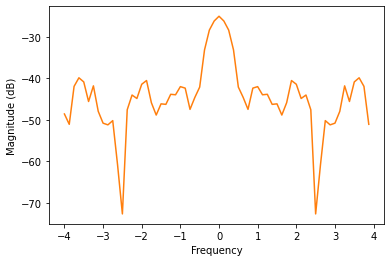

400  loss: 0.9964747428894043
400  acc: 0.518310010433197


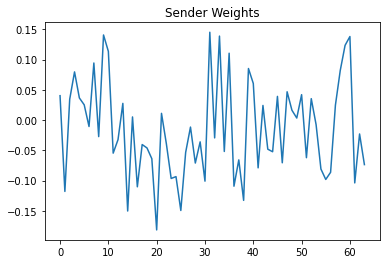

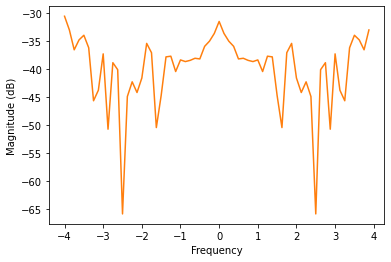

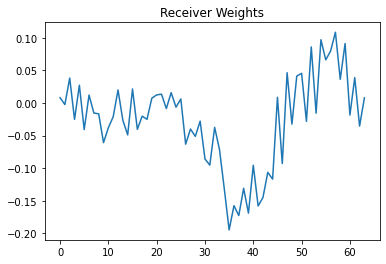

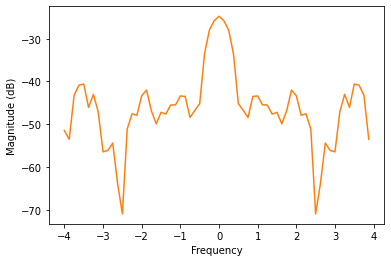

500  loss: 0.9888381361961365
500  acc: 0.5261399745941162


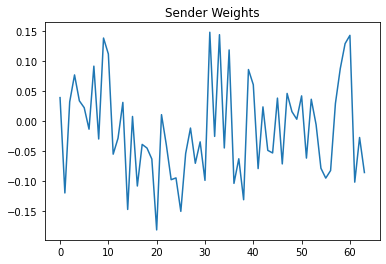

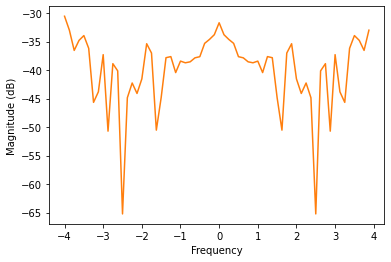

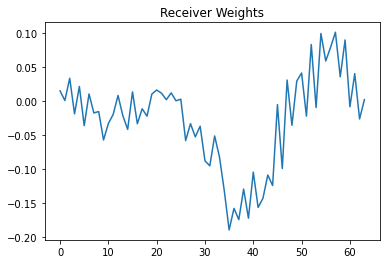

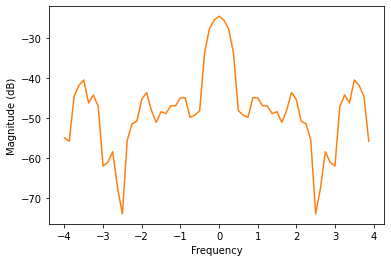

600  loss: 0.9847468137741089
600  acc: 0.527239978313446


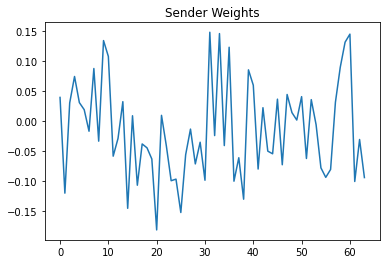

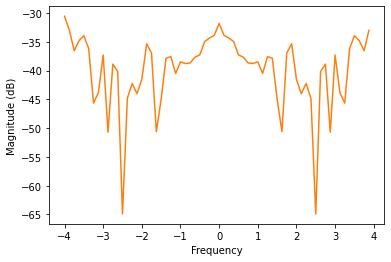

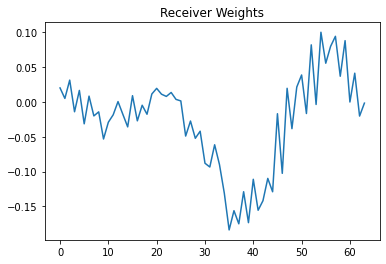

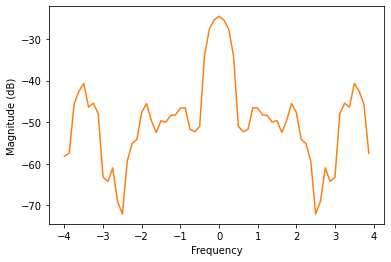

700  loss: 0.9813905954360962
700  acc: 0.5306299924850464


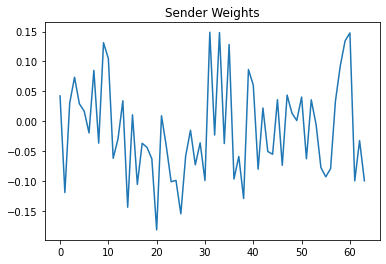

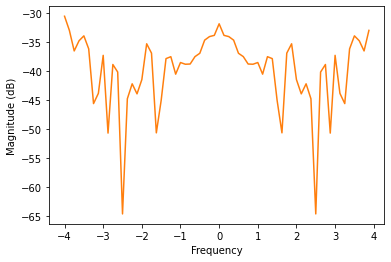

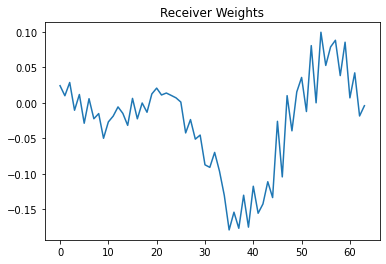

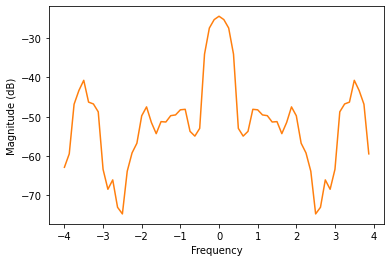

800  loss: 0.9811423420906067
800  acc: 0.5293499827384949


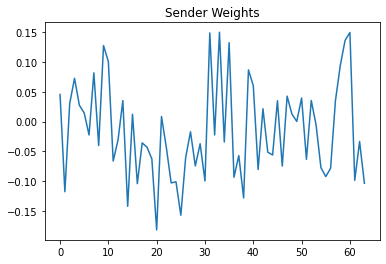

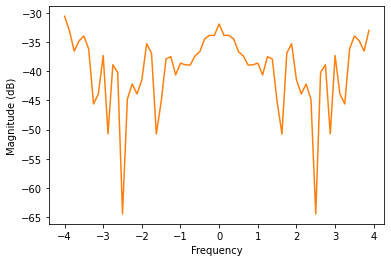

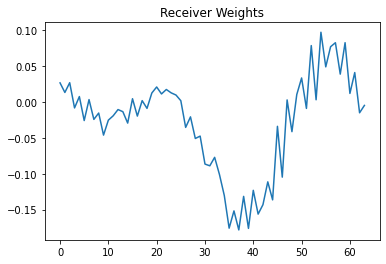

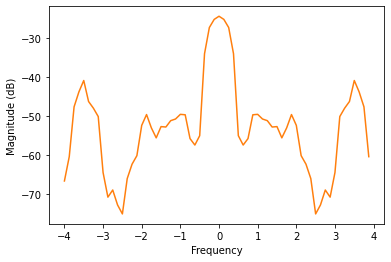

900  loss: 0.9792829751968384
900  acc: 0.5318999886512756


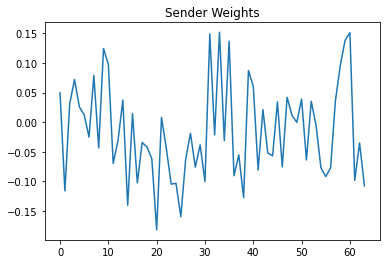

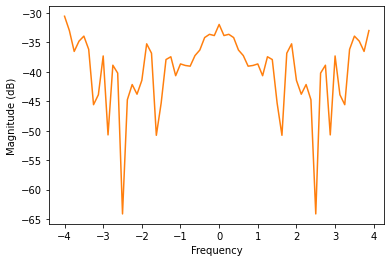

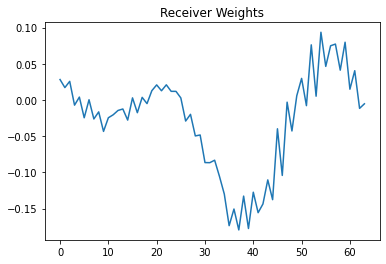

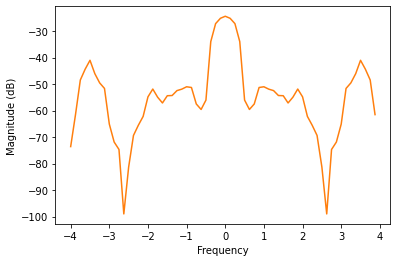

1000  loss: 0.9792694449424744
1000  acc: 0.5304200053215027


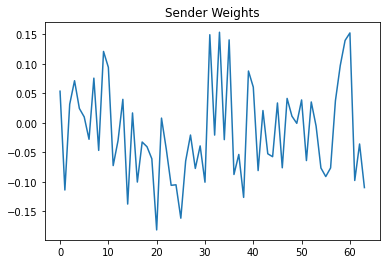

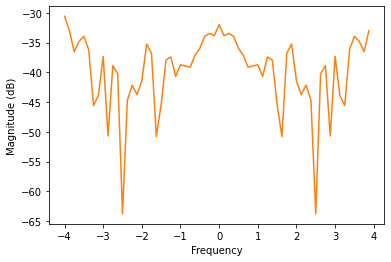

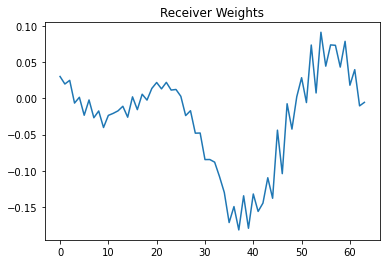

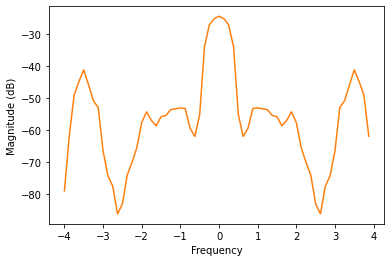

1100  loss: 0.9779139757156372
1100  acc: 0.5311700105667114


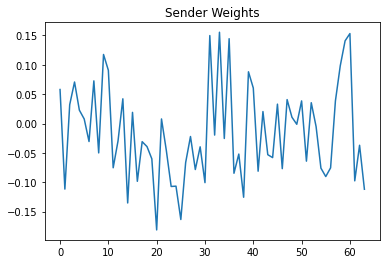

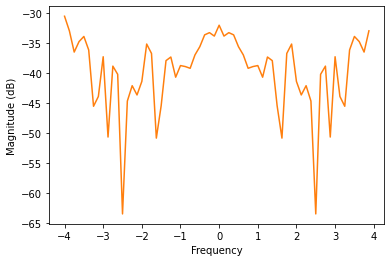

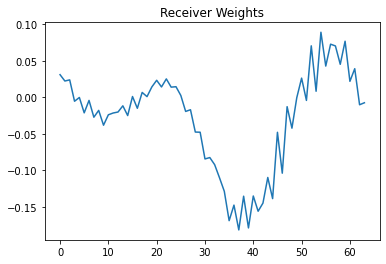

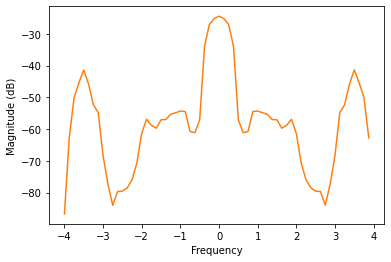

1200  loss: 0.9783663153648376
1200  acc: 0.5323399901390076


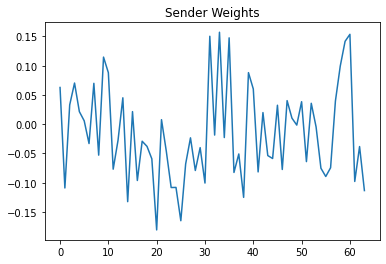

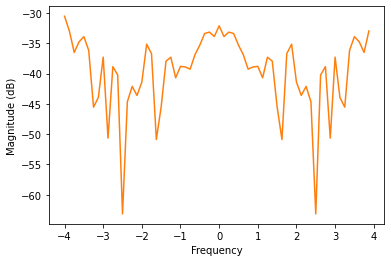

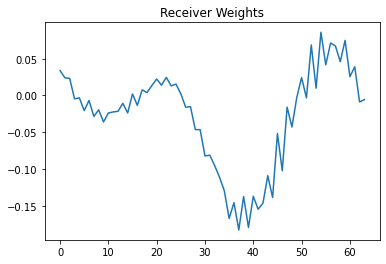

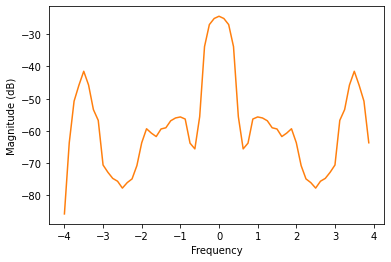

1300  loss: 0.9787942171096802
1300  acc: 0.5313799977302551


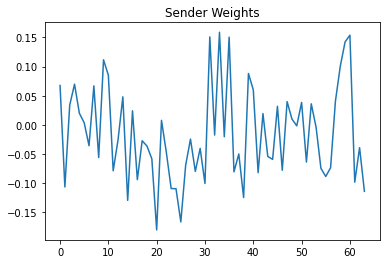

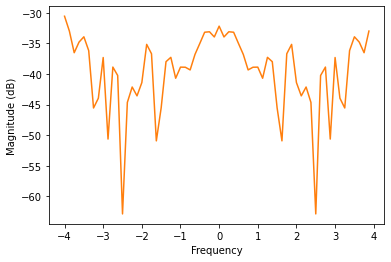

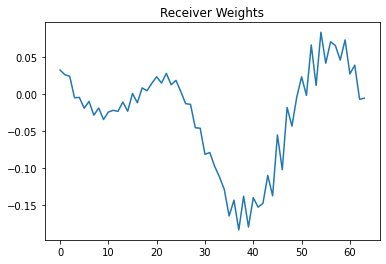

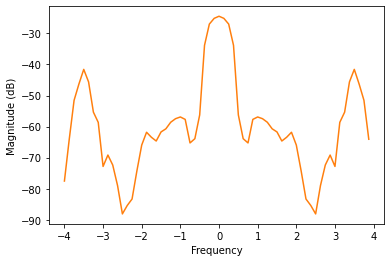

1400  loss: 0.9783757925033569
1400  acc: 0.5328699946403503


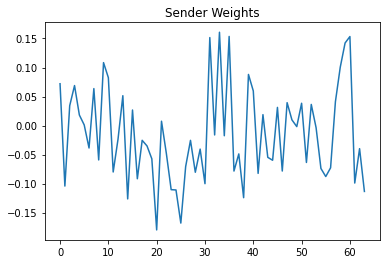

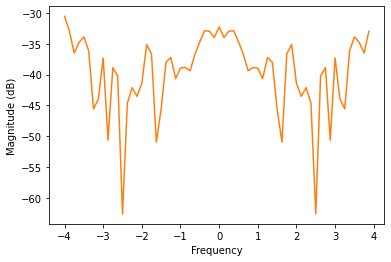

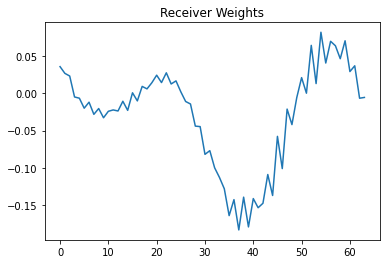

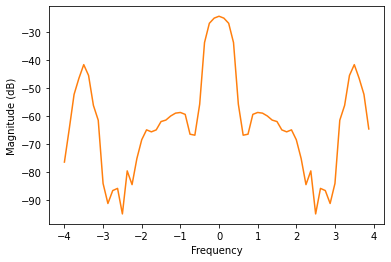

1500  loss: 0.9779996275901794
1500  acc: 0.5321899652481079


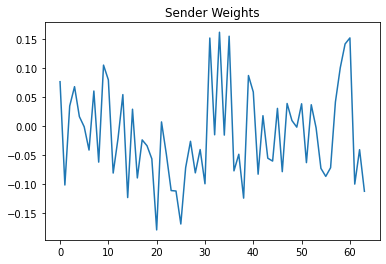

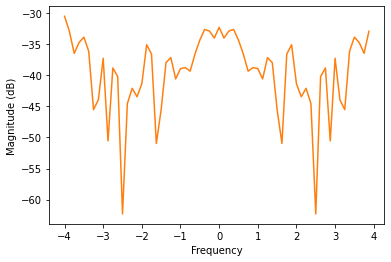

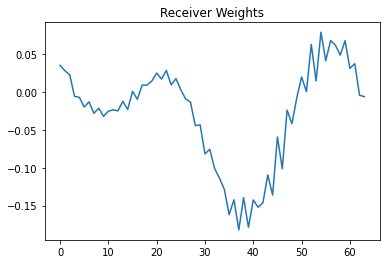

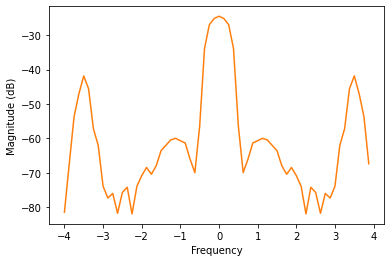

1600  loss: 0.978121817111969
1600  acc: 0.5297999978065491


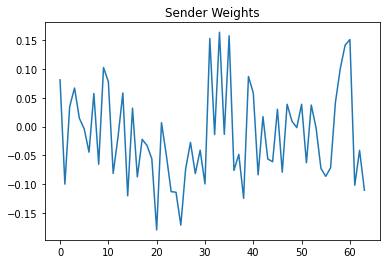

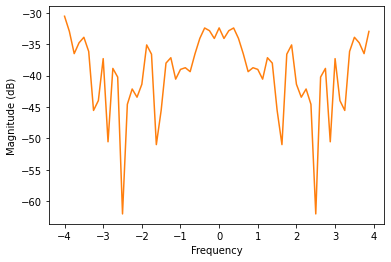

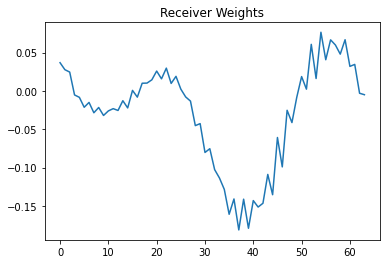

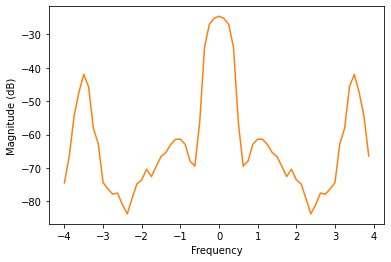

1700  loss: 0.977912187576294
1700  acc: 0.5322499871253967


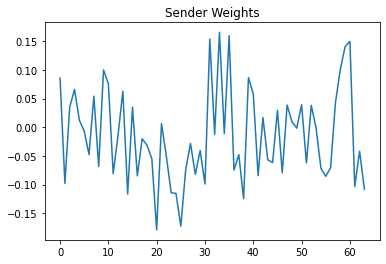

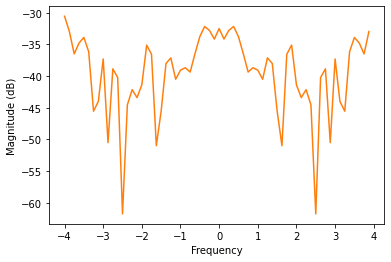

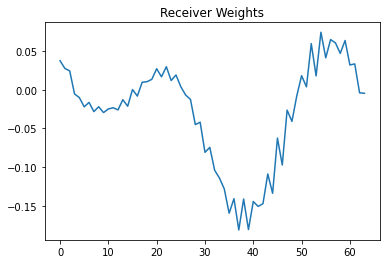

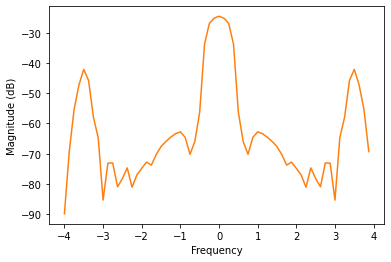

1800  loss: 0.9775524139404297
1800  acc: 0.533050000667572


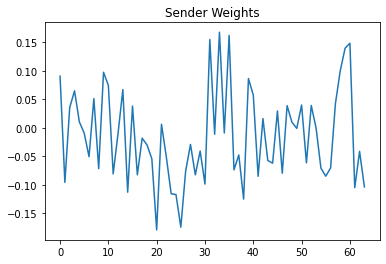

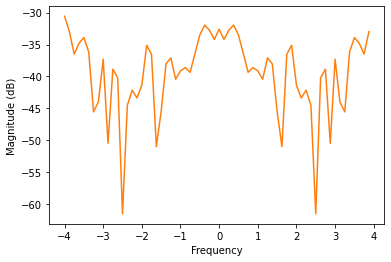

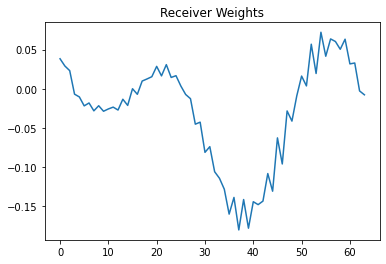

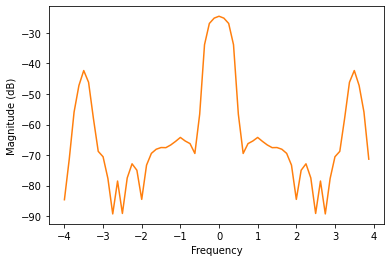

1900  loss: 0.9779025912284851
1900  acc: 0.5317599773406982


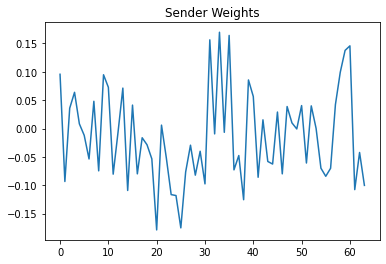

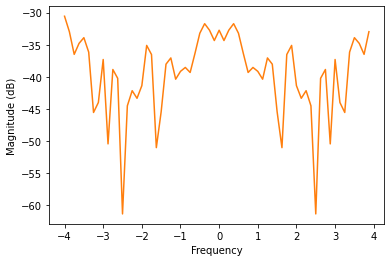

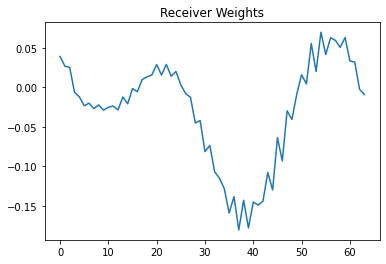

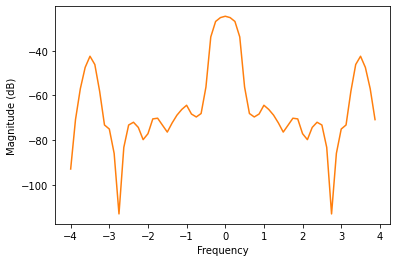

2000  loss: 0.9780062437057495
2000  acc: 0.5342699885368347


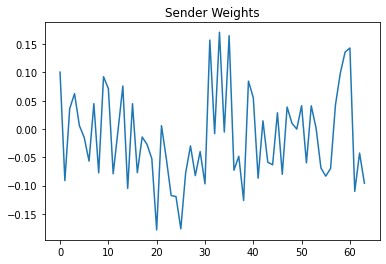

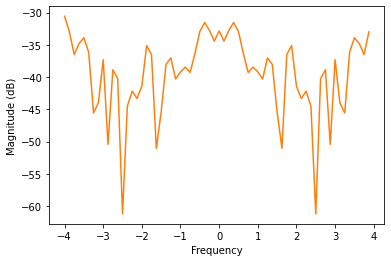

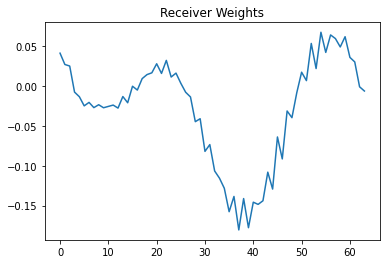

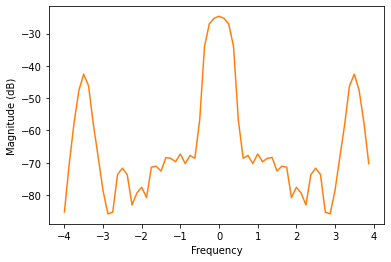

2100  loss: 0.9780901074409485
2100  acc: 0.5318099856376648


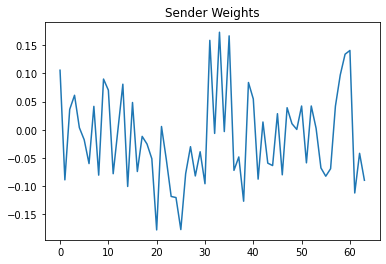

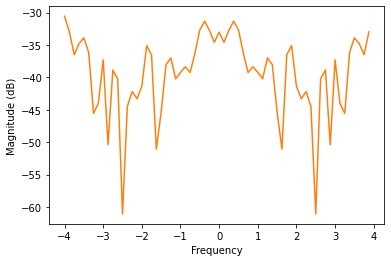

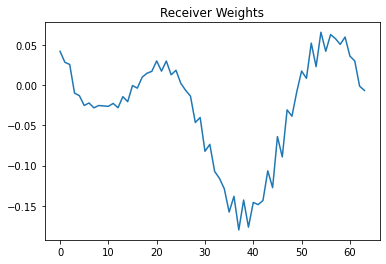

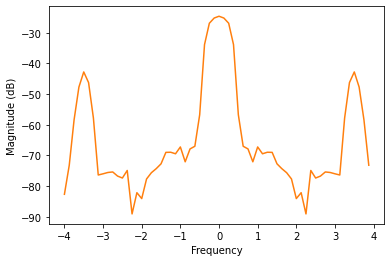

2200  loss: 0.9780094027519226
2200  acc: 0.5321599841117859


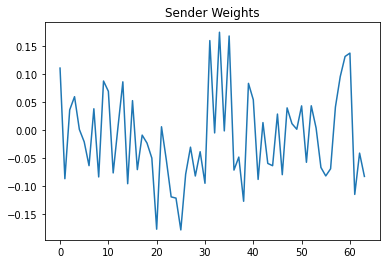

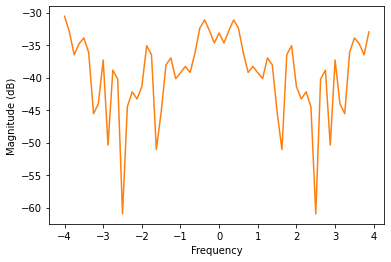

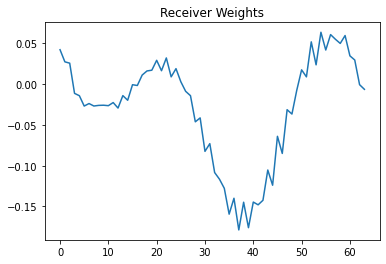

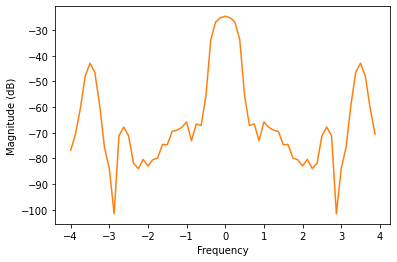

2300  loss: 0.9780617952346802
2300  acc: 0.5314499735832214


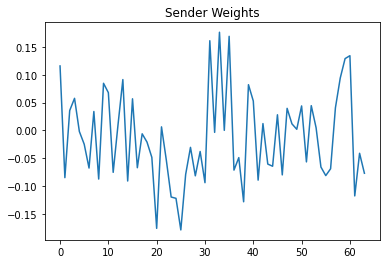

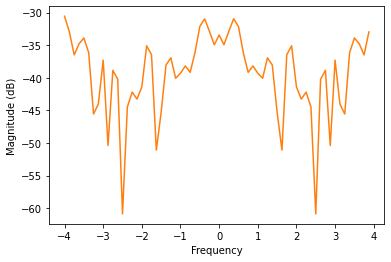

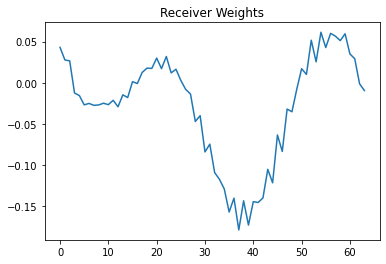

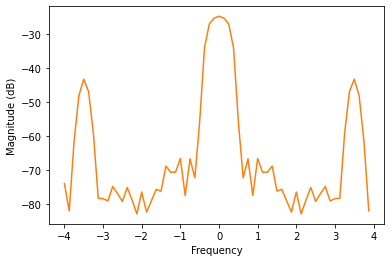

2400  loss: 0.9783897399902344
2400  acc: 0.5333399772644043


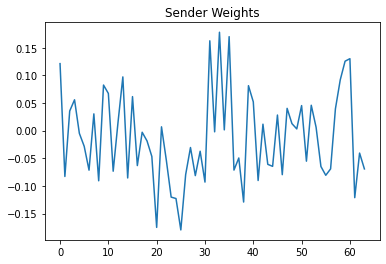

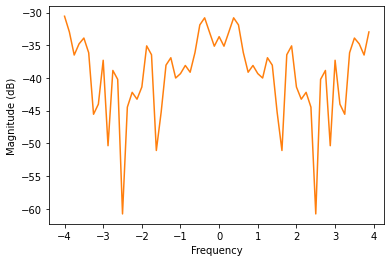

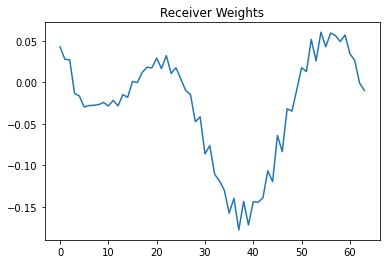

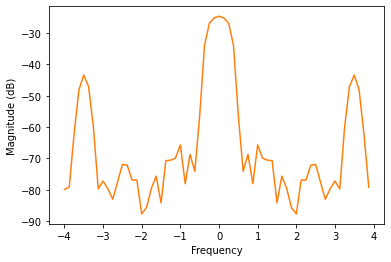

2500  loss: 0.9781113266944885
2500  acc: 0.5340299606323242


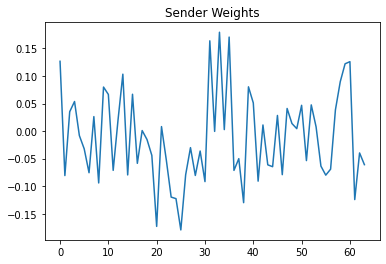

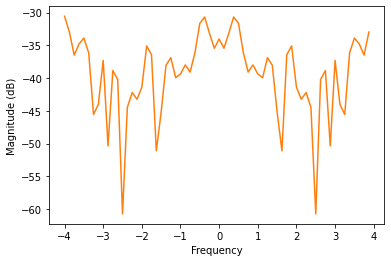

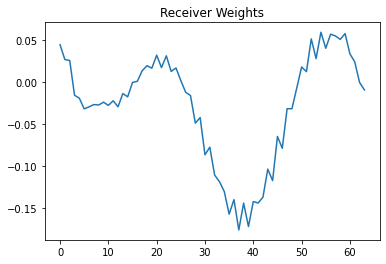

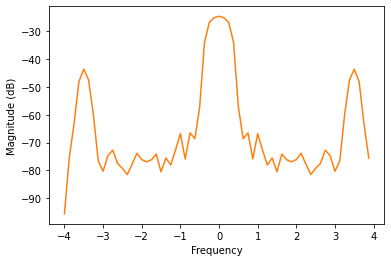

2600  loss: 0.9784776568412781
2600  acc: 0.5313999652862549


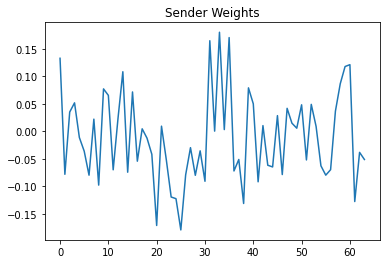

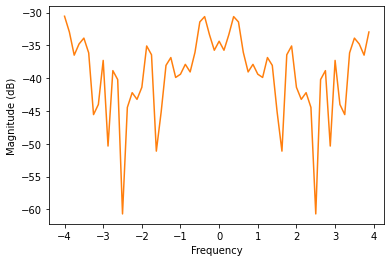

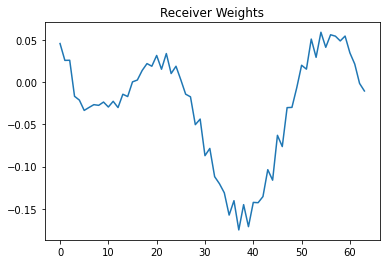

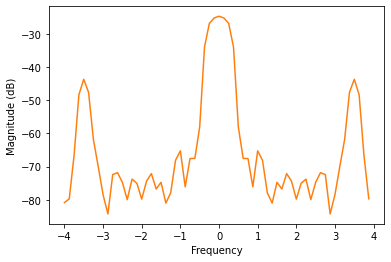

2700  loss: 0.9773882627487183
2700  acc: 0.5320900082588196


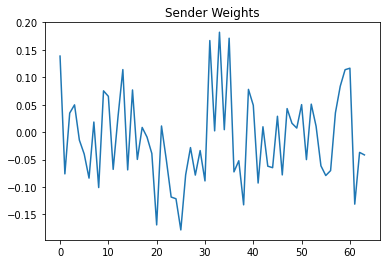

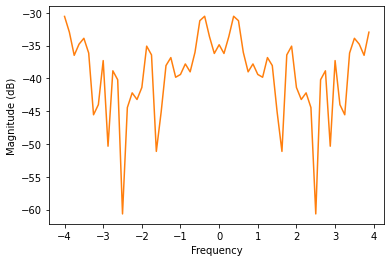

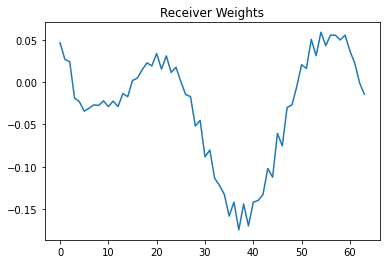

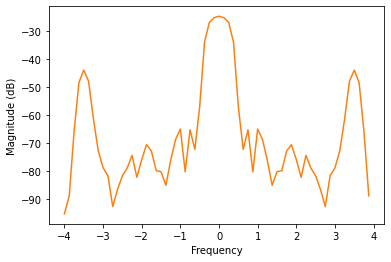

2800  loss: 0.9773322939872742
2800  acc: 0.534309983253479


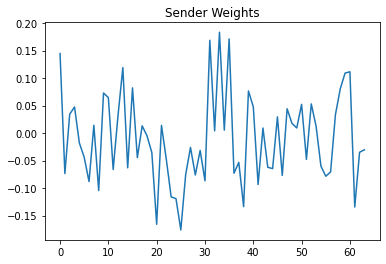

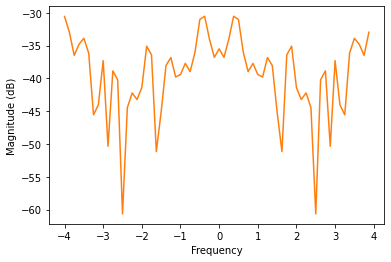

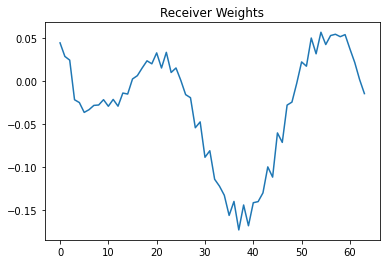

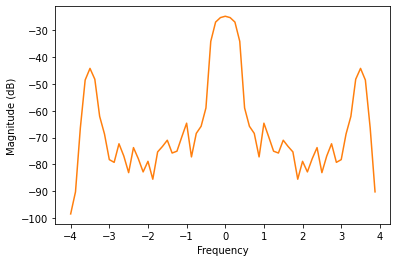

2900  loss: 0.9778479933738708
2900  acc: 0.5309799909591675


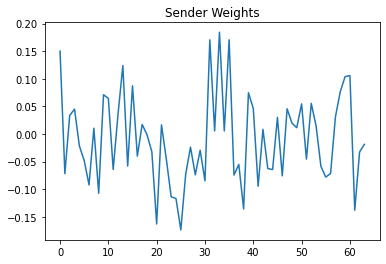

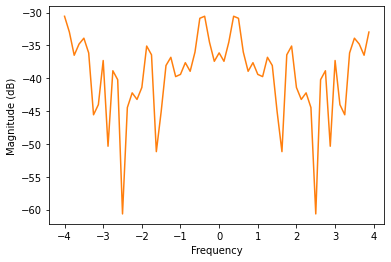

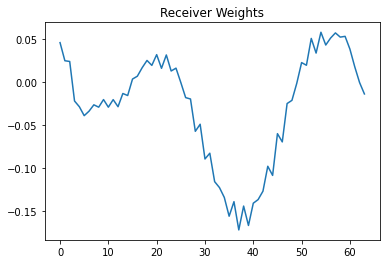

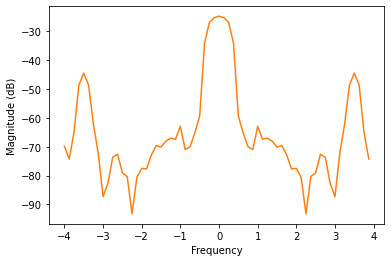

3000  loss: 0.9770119786262512
3000  acc: 0.5325199961662292


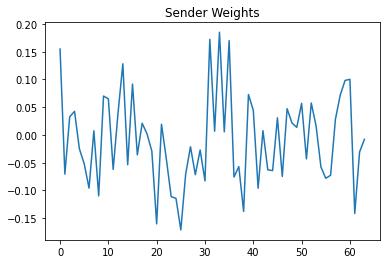

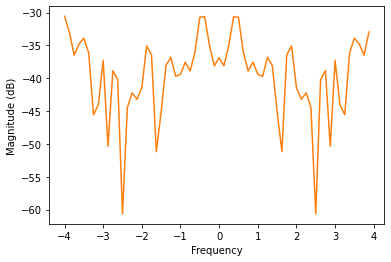

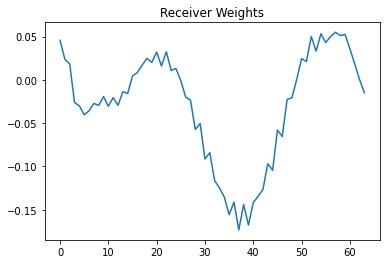

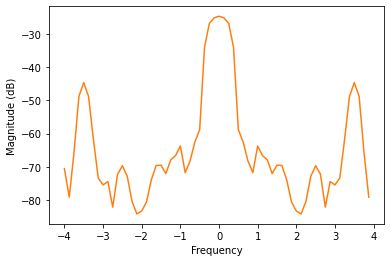

3100  loss: 0.9784470796585083
3100  acc: 0.5311499834060669


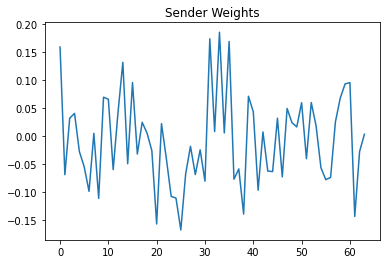

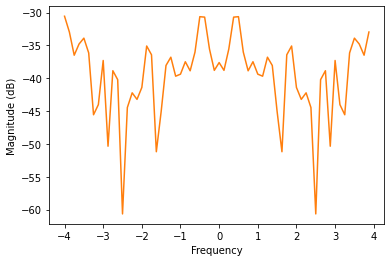

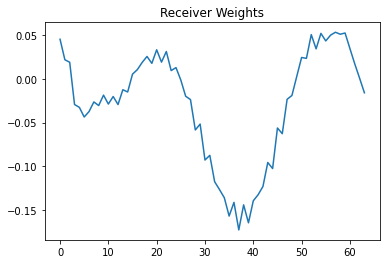

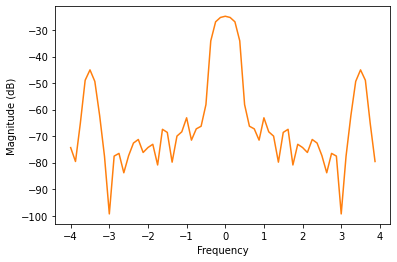

3200  loss: 0.9778354167938232
3200  acc: 0.5322099924087524


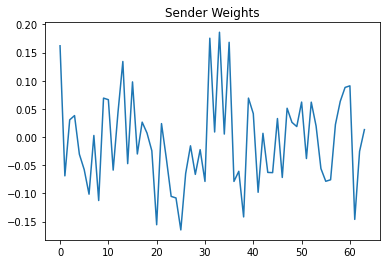

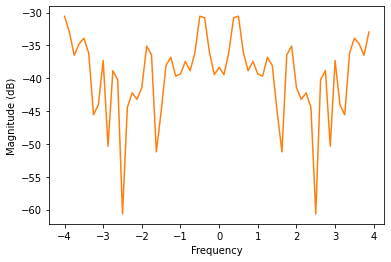

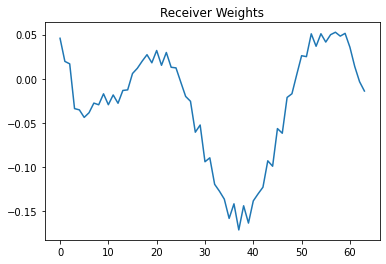

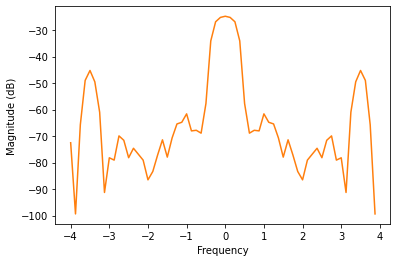

3300  loss: 0.9778830409049988
3300  acc: 0.5321199893951416


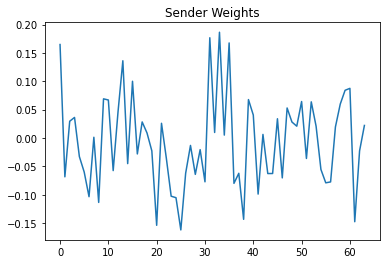

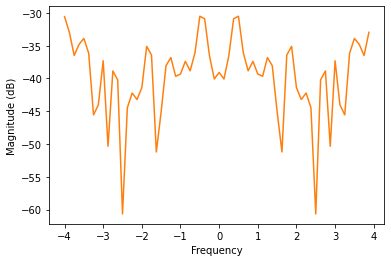

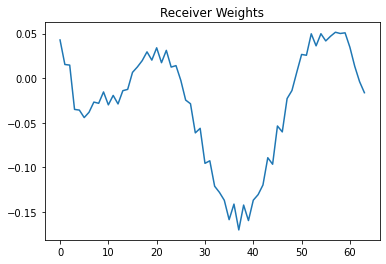

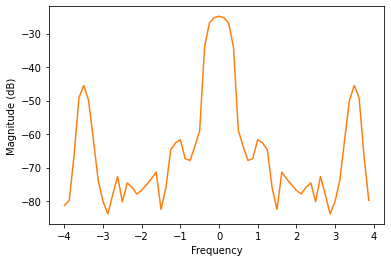

3400  loss: 0.9772903323173523
3400  acc: 0.5335999727249146


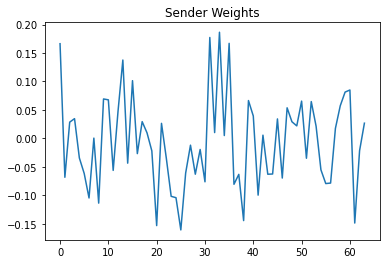

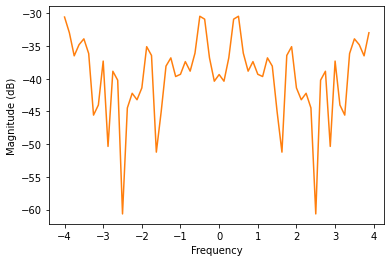

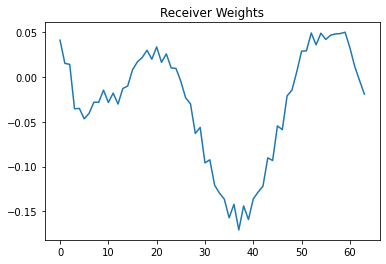

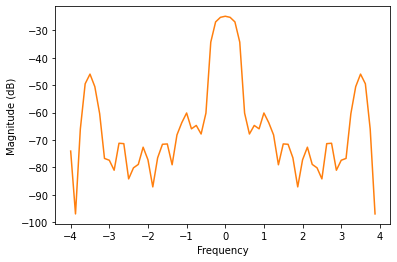

3500  loss: 0.9779954552650452
3500  acc: 0.5346099734306335


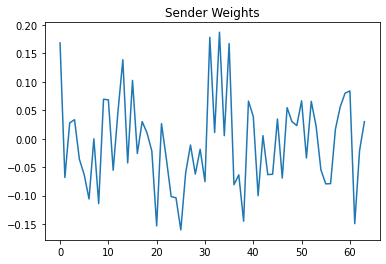

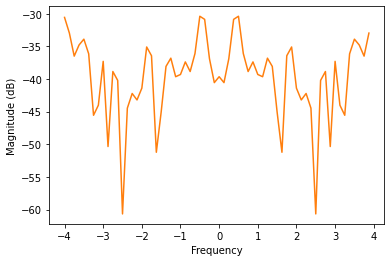

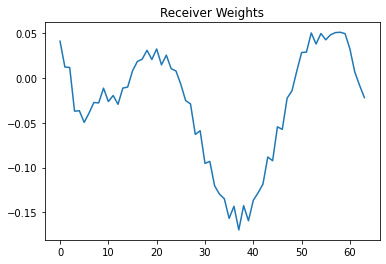

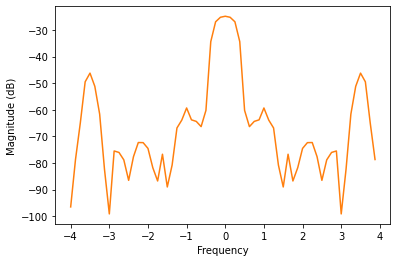

3600  loss: 0.9774007201194763
3600  acc: 0.5330899953842163


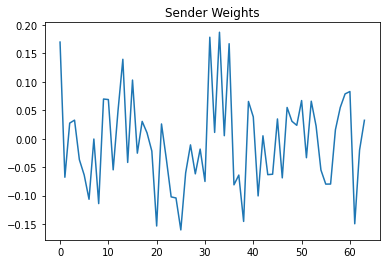

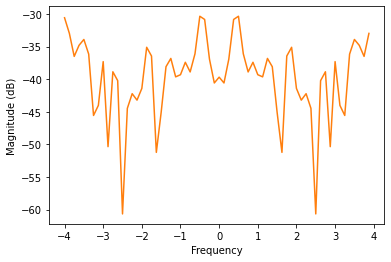

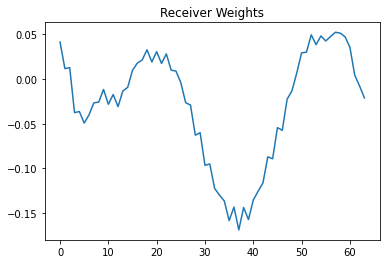

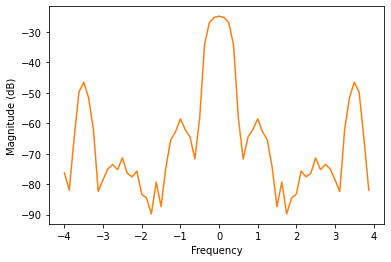

3700  loss: 0.978495717048645
3700  acc: 0.5343799591064453


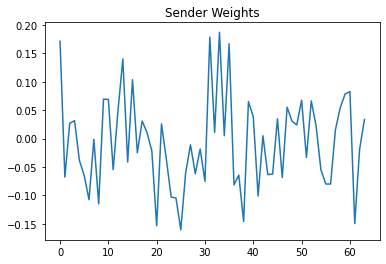

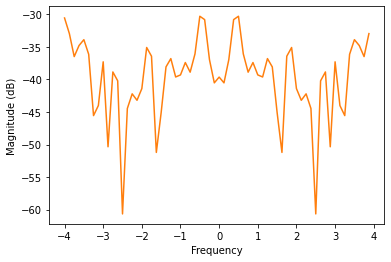

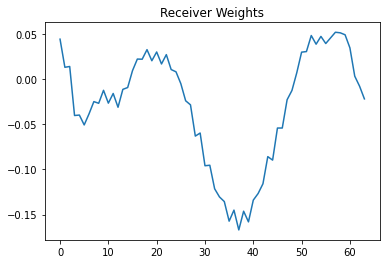

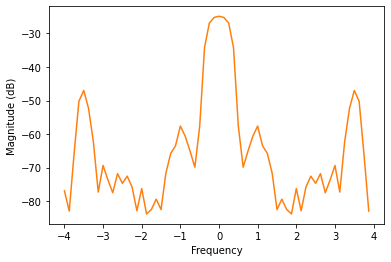

3800  loss: 0.9773877263069153
3800  acc: 0.5328800082206726


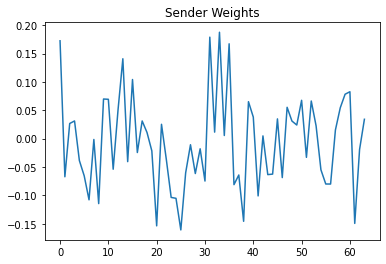

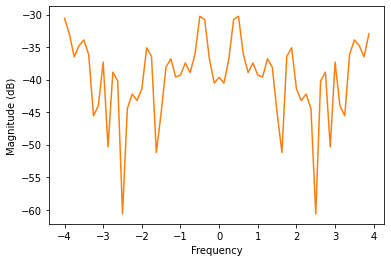

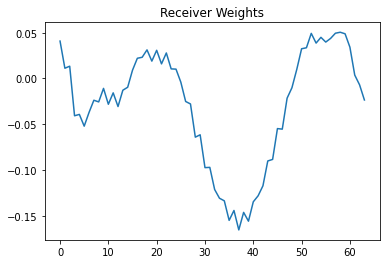

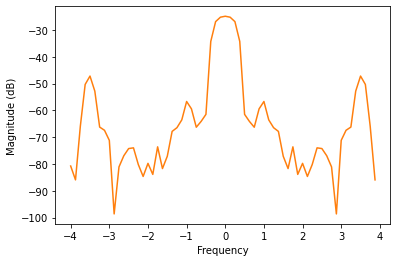

3900  loss: 0.9780852198600769
3900  acc: 0.5311200022697449


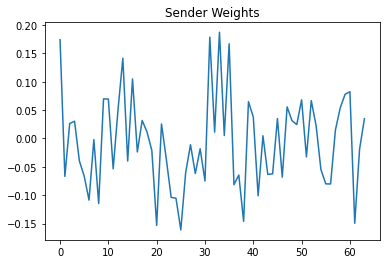

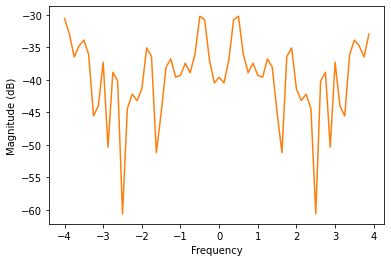

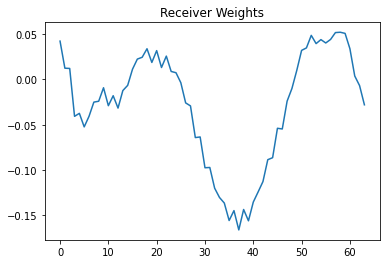

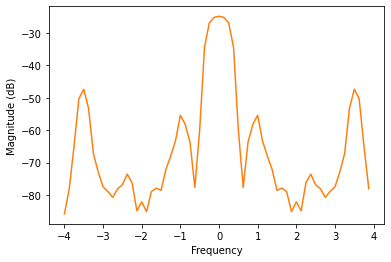

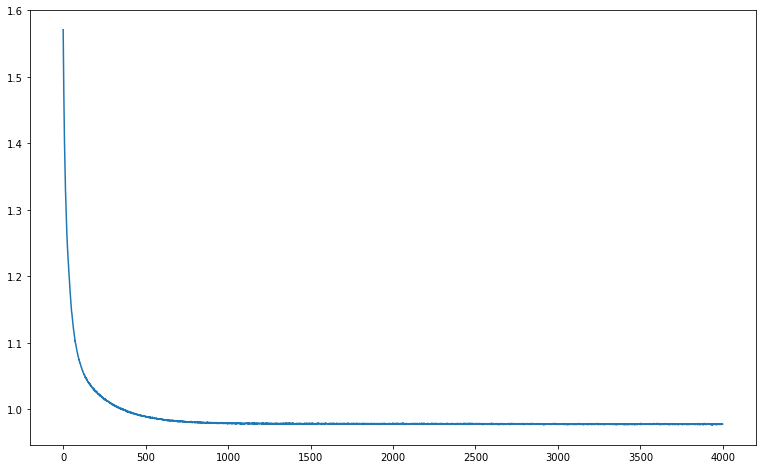

In [4]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, sample_rate=CS.m, 
                                epochs=4000, cutoff_freq=0.3, v=True, use_cuda=True, SNRdb=10, plot_iteration=100,
                               lowpass='ideal')

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [7]:
# Evaluate

NN_tx.to('cpu')
NN_rx.to('cpu')

SNR = 10
joint_decisions = CS.transmission(SNRdb=SNR, mode='joint', joint_cutoff=0.3, model=[NN_tx, NN_rx], lowpass='ideal')
#euclid_decisions = CS.transmission(SNRdb=SNR, mode='euclidean')

print('Accuracy:', 1 - CS.evaluate(joint_decisions)[1])
#print('Accuracy:', 1 - CS.evaluate(euclid_decisions)[1])

Accuracy: 0.5324800000000001


In [ ]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er,  error_theory = \
SNR_plot(num_symbols=200000, joint_cutoff=1, joint_models=[NN_tx, NN_rx], lowpass='ideal') #[NN_tx, NN_rx]
                                                                                          

plt.figure(figsize=(18,11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRdbs[num:], euclid_er[num:])
#plt.semilogy(SNRdbs[num:], NN_er[num:])
#plt.semilogy(SNRdbs[num:], block_er[num:])
plt.semilogy(SNRdbs[num:], network_er[num:])
plt.semilogy(SNRdbs[num:], joint_er[num:], alpha=1)
plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=1)
legend0 = ['Receiver Network', 'Theory']
legend1 = ['Euclidean', 'Receiver Network', 'Joint Networks', 'Theory']
legend2 = ['Euclidean', 'NN Dec Maker', 'Block', 'Receiver Network', 'Joint Networks', 'Theory']
plt.legend(legend1, fontsize=16)
plt.show()